### **CartPole-v1 (maximum 500 steps)**
#### Single Neural Network With Experience Replay
#### The input to the network consists of 4 float values (Cart Position, Cart Velocity, Pole Angle and Pole Velocity at the Tip).
#### The outputs of the network don't go through any activation function; instead of probabilities, the outputs are directly state-action values.
##### (The optimal policy involves choosing the Argmax of the output vector of the Neural Network as the action for the next step).
##### **This environment is considered to be solved when getting an average of 475 over 100 consecutive episodes.**

In [1]:
# Imports the libraries and creates the model
# Hyperparameter tuning was carried out for the model (learning_rate, optimizers, batch_size, etc.) and for the learning loop (number of replay steps, discount factor, epsilon_decay, etc.)

import random
import numpy as np
from tensorflow import keras
import gym
env = gym.make('CartPole-v1')
model = keras.Sequential()
model.add (keras.layers.Dense(units = 32, input_shape=(4,), activation = "relu"))
model.add (keras.layers.Dense(units = 32, activation = "relu"))
model.add (keras.layers.Dense(units = 8, activation = "relu"))
model.add (keras.layers.Dense(units = 8, activation = "relu"))
model.add (keras.layers.Dense(units = 2))
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss ="mse")
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total params: 1,570
Trainable params: 1,570
Non-trainable params: 0
_________________________________________________________________
None


In [2]:
# Memory Replay is carried out in this function.
# 32 random previous experiences per step are used to fit the model without overfitting most recent states
# This function has been vectorised with numpy "Put_along_axis" function (see comment down below) to avoid a slow for loop.

def executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryARD, model, itemsInMemory):
    randomList = np.random.permutation(itemsInMemory) # After that position, everything is 0 in Memory
    
    memoryPreviousStates = memoryPreviousStates[randomList[:numberOfLearningFromReplaySteps]] # Shape: (32, 1)
    memoryStates = memoryStates[randomList[:numberOfLearningFromReplaySteps]] # Shape: (32, 1)
    memoryARD = memoryARD[randomList[:numberOfLearningFromReplaySteps]] # Shape: (32, 3) Action, Reward, Done

    # These variables are vectorised and contain the whole batch:
    
    previousState = memoryPreviousStates 
    
    state = memoryStates
    
    
    action, reward, done = np.split(memoryARD,3,axis=1)
    
    action = action.astype(int)
    
    target = model.predict(previousState)
    
    # This function changes the value for the action selected in "action" into the "target" array.
    # I.e., for each row, one of the two columns are modified, these indexes (0 or 1) for each row appear in the "action" array
    # The individual updates are those of the Q-learning algorithm: only the reward obtained if done=False=0 and the reward plus the discounted value of the next state if done=True=1
    
    np.put_along_axis(target, action, (reward + (1-done)*discount*np.expand_dims(np.amax(model.predict(state), axis=1),axis=1)), axis =1)
    
    
    targetArray = np.array(target)
    
    model.fit(memoryPreviousStates, targetArray, epochs=1, verbose = 0, batch_size =1)


In [3]:
def checkIfTheseWeightsAreOptimal (model):

# This function checks if our weights are optimal.
# The environment is considered to be solved if its average over 100 consecutive episodes is over 475.0. Doing sanity checks at the power-of-2 episodes avoid completing the whole testing loop if the weights are not good:

    rewards = []
    for episode in range (100):
        
        done = False
        prevObs = env.reset()

        episodeReward = 0
        for step in range (600):
            if done:
                break
            env.render()

            target = model.predict(np.expand_dims(prevObs, axis = 0))[0]
            action = np.argmax(target)

            obs, reward, done, _ = env.step (action)



            prevObs = obs
            episodeReward += reward

        rewards.append(episodeReward)
        
        if (episode in [0,1,3,7,15,31,63]):
            if (np.average(rewards)<450):
                env.close()
                return False
            else:
                print ("Up until the episode number ", (episode+1), ". The average reward looks promising...")
        
    if (np.average(rewards)>=475):
        import matplotlib.pyplot as plt
        plt.plot (list(range(len(rewards))), rewards)
        plt.title("Rewards obtained along the testing process")
        plt.xlabel("Episode number")
        plt.ylabel("Reward obtained")
        plt.show()
        return True
    else:
        return False

0  Episode Reward:  31.0 .Epsilon: 0.995
Weights are not optimal
1  Episode Reward:  12.0 .Epsilon: 0.990025
2  Episode Reward:  13.0 .Epsilon: 0.985074875
3  Episode Reward:  31.0 .Epsilon: 0.9801495006250001
4  Episode Reward:  12.0 .Epsilon: 0.9752487531218751
5  Episode Reward:  15.0 .Epsilon: 0.9703725093562657
6  Episode Reward:  14.0 .Epsilon: 0.9655206468094844
7  Episode Reward:  74.0 .Epsilon: 0.960693043575437
8  Episode Reward:  17.0 .Epsilon: 0.9558895783575597
9  Episode Reward:  23.0 .Epsilon: 0.9511101304657719
10  Episode Reward:  16.0 .Epsilon: 0.946354579813443
Weights are not optimal
11  Episode Reward:  16.0 .Epsilon: 0.9416228069143757
12  Episode Reward:  15.0 .Epsilon: 0.9369146928798039
13  Episode Reward:  26.0 .Epsilon: 0.9322301194154049
14  Episode Reward:  13.0 .Epsilon: 0.9275689688183278
15  Episode Reward:  15.0 .Epsilon: 0.9229311239742362
16  Episode Reward:  18.0 .Epsilon: 0.918316468354365
17  Episode Reward:  28.0 .Epsilon: 0.9137248860125932
18  E

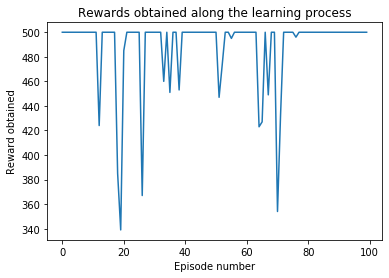

Weights are optimal


In [4]:
# Main Training Loop

numberEpisodes = 500

discount = 0.99
counter = 0
epsilon = 1
epsilonDecay = 0.995
rewards = []

memorySize = 2000
memoryPreviousStates = np.zeros((memorySize,4))
memoryStates = np.zeros((memorySize,4))
memoryARD = np.zeros((memorySize,3))
numberOfLearningFromReplaySteps = 32
itemsInMemory = 0
initialiseReplayAfter = 300 
optimalWeights = False
for episode in range (numberEpisodes):
    if (optimalWeights): # Stop the training if we already have "perfect" weights
        break
        
    epsilon = max (epsilon*epsilonDecay, 0.1)
  
    done = False
    prevObs = env.reset()
    
    episodeReward = 0
    for step in range (600):
        if done:
            break
        #env.render()
        
       
      
        target = model.predict(np.expand_dims(prevObs, axis = 0))[0]
        if (random.random()<epsilon):
            action = random.choice([0,1])
        else:
            action = np.argmax(target)
        
        obs, reward, done, _ = env.step (action)

       

        memoryPreviousStates[counter] = prevObs
        memoryStates[counter] = obs
        if (episodeReward <= 498):
            memoryARD[counter] = [float(action), reward, float (done)]
        else: # Is not the fault of the agent's action that the environment restarts after 500 epochs. So we set done=False for the memory replay
            memoryARD[counter] = [float(action), reward, float (0)]


        if (itemsInMemory < (counter+1)):
            itemsInMemory = min ((itemsInMemory+1), memorySize)
        if (itemsInMemory >= initialiseReplayAfter): # After a few episodes, Memory Replay is activated
            executeMemoryReplayStep(memoryPreviousStates, memoryStates, memoryARD, model, itemsInMemory)
      

        prevObs = obs
        episodeReward += reward
        counter = (counter + 1) % memorySize
    print (episode, " Episode Reward: ", episodeReward, ".Epsilon:", epsilon)
    rewards.append(episodeReward)
    if (episode % 10 ==0):
        if (checkIfTheseWeightsAreOptimal(model)):
            model.save_weights("BestWeights2.h5")
            print ("Weights are optimal")
            optimalWeights = True
        else:
            print ("Weights are not optimal")

env.close()

### Even though the scores obtained before getting the optimal weights are rather low (around 150.0) compared to the maximum score (500.0), it should be considered that, at that point, epsilon was above 0.6. That means than more than 60% of the times the action was chosen randomly and the agent managed to score almost 150.0 nevertheless. If we don't check for optimal weights and keep the training loop going, we obtain a graph that is more stable and needs fewer episodes than the single network without memory replay.
### This is the first algorithm with which we have obtained weights that can solve the environment (when stopping the training, the algorithm gets an average over 475.0 for 100 consecutive episodes)
### Further research with a Double Neural Network improved the stability of the algorithm